## Import Required Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string # to count punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.svm import SVC

## Data Exploration
Include data preparation and data cleaning

In [3]:
# open datatset, encoding is needed due to format issue from dataset
df = pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [4]:
# check the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# check on null data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df['Unnamed: 2'][df['Unnamed: 2'].notnull()].head(5)

95                                           PO Box 5249
281     the person is definitely special for u..... B...
444     HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...
671     wanted to say hi. HI!!!\" Stop? Send STOP to ...
710      this wont even start........ Datz confidence.."
Name: Unnamed: 2, dtype: object

**Notes:** <br>
Based on quick observation, it seems that those unnamed columns might contain some data. Need to check the content of those non-null data

In [7]:
df['Unnamed: 3'][df['Unnamed: 3'].notnull()].head(5)

95                          MK17 92H. 450Ppw 16"
281                             why to miss them
899                         MK17 92H. 450Ppw 16"
1038                                          GE
2170    U NO THECD ISV.IMPORTANT TOME 4 2MORO\""
Name: Unnamed: 3, dtype: object

In [8]:
df['Unnamed: 4'][df['Unnamed: 4'].notnull()].head(5)

281                         just Keep-in-touch\" gdeve.."
1038                                              GNT:-)"
2255     Never comfort me with a lie\" gud ni8 and swe...
3525                  CALL 2MWEN IM BK FRMCLOUD 9! J X\""
4668      one day these two will become FREINDS FOREVER!"
Name: Unnamed: 4, dtype: object

**Notes:** <br>
Non-null data contains extension of message from v2 column, need to combine these columns with v2 column

In [9]:
# create new columns, called message
df['message'] = df[['v2','Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].fillna('').agg(','.join, axis=1)

In [10]:
# clean unneeded 'character on message column
df['message']=df['message'].str.replace(r'\\','', regex=True)


In [11]:
# rename v1 column to label, as ham means that data is alright while spam is a spam
df = df.rename(columns={'v1':'label'})

In [12]:
# drop unneded column
df = df.drop(["v2","Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)

In [13]:
# count how many ham and how many spam
df['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [14]:
#create column to store count of character length
df['char_length'] = 0


In [15]:
# fill up char_length column with character length
for index, row in df.iterrows():
  df.at[index,'char_length']=len(row['message'])

In [16]:
#create column to store count of character length
df['punct_length'] = 0

In [17]:
# fill up punct_length column with character length
for index, row in df.iterrows():
  punct_count = 0
  for i in row['message']:
    if i in string.punctuation:
      punct_count += 1
  
  df.at[index,'punct_length'] = punct_count

In [18]:
df

,label,message,char_length,punct_length
0,ham,"Go until jurong point, crazy.. Available only ...",114,12
1,ham,"Ok lar... Joking wif u oni...,,,",32,9
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,158,9
3,ham,U dun say so early hor... U c already then say...,52,9
4,ham,"Nah I don't think he goes to usf, he lives aro...",64,5
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,164,11
5568,ham,"Will Ì_ b going to esplanade fr home?,,,",40,5
5569,ham,"Pity, * was in mood for that. So...any other s...",60,10
5570,ham,The guy did some bitching but I acted like i'd...,128,4


## Balancing the data
Make value ham and spam are equal

In [19]:
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

In [20]:
ham.shape, spam.shape

((4825, 4), (747, 4))

In [21]:
# reduce ham data to equal to spam data
new_ham = ham.sample(747)

In [22]:
new_ham.shape

(747, 4)

In [23]:
# merge new_ham and spam data to create new dataset with more balanced label
new_df = pd.concat([new_ham,spam],ignore_index=True)

In [24]:
new_df['label'].value_counts()

ham     747
spam    747
Name: label, dtype: int64

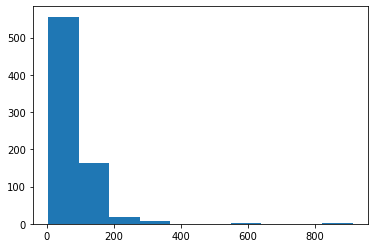

In [25]:
plt.hist(new_df[new_df['label'] == 'ham']['char_length'])
plt.show()

## Splitting data to test and train data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(new_df['message'], new_df['label'], test_size = 0.3, random_state= 0, shuffle =True)

In [27]:
x_test.shape

(449,)

## Random Forest Classifier

In [28]:
classifier = Pipeline([("tfidf", TfidfVectorizer()),("classifier",RandomForestClassifier(n_estimators=100))])

In [29]:
classifier.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [30]:
y_pred = classifier.predict(x_test)

In [31]:
y_test, y_pred

(799     spam
 1047    spam
 1436    spam
 54       ham
 793     spam
         ... 
 824     spam
 822     spam
 644      ham
 1034    spam
 1356    spam
 Name: label, Length: 449, dtype: object,
 array(['spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham',
        'ham', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam',
        'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham',
        'ham', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham',
        'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam',
        'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham',
        'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'spam',
        'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam',

In [32]:
accuracy_score(y_test, y_pred)

0.9532293986636972

In [33]:
confusion_matrix(y_test, y_pred)

array([[227,   0],
       [ 21, 201]])

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.92      1.00      0.96       227
        spam       1.00      0.91      0.95       222

    accuracy                           0.95       449
   macro avg       0.96      0.95      0.95       449
weighted avg       0.96      0.95      0.95       449



## Support Vector Machine

In [35]:
svm = Pipeline([("tfidf", TfidfVectorizer()),("classifier",SVC(C =100, gamma='auto'))])

In [36]:
svm.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', SVC(C=100, gamma='auto'))])

In [37]:
y_pred = svm.predict(x_test)

In [38]:
accuracy_score(y_test,y_pred)

0.9510022271714922

In [39]:
confusion_matrix(y_test, y_pred)

array([[225,   2],
       [ 20, 202]])

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.92      0.99      0.95       227
        spam       0.99      0.91      0.95       222

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449



## Prediction

In [41]:
test1 = ['Congratulations, you won a free trips to Japan !! Call 911001 now!']
test2 = ['Happy Birthday, wish you all the best !']
test3 = ['What time you will reach here ?']

### Random Forest Prediction

In [43]:
print(classifier.predict(test1))
print(classifier.predict(test2))
print(classifier.predict(test3))


['spam']
['ham']
['ham']


### SVM Predicition

In [44]:
print(classifier.predict(test1))
print(classifier.predict(test2))
print(classifier.predict(test3))

['spam']
['ham']
['ham']
